In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [145]:
project_path = Path("..")
data_path = project_path/"datasets"
models_path = project_path/"models"

In [6]:
df_compas = pd.read_csv(data_path/"compas_for_fairlearn.csv")
df_compas.head()

,entity_id,sex,age_cat,race,priors_count,c_charge_degree,label_value
0,1,Male,Greater than 45,Other,0,F,0
1,3,Male,25 - 45,African-American,0,F,1
2,4,Male,Less than 25,African-American,4,F,1
3,5,Male,Less than 25,African-American,1,F,0
4,6,Male,25 - 45,Other,2,F,0


In [8]:
df_compas["label_value"].value_counts()

0    3963
1    3251
Name: label_value, dtype: int64

In [151]:
import joblib

from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer

import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [150]:
df_compas_train, df_compas_test = train_test_split(df_compas, 
                                                   test_size=0.15, 
                                                   stratify=df_compas["label_value"])
df_compas_train, df_compas_val = train_test_split(df_compas_train, 
                                                   test_size=0.2, 
                                                   stratify=df_compas_train["label_value"])

In [110]:
cat_columns_mask = df_compas_train.columns[:-1].map(
    lambda x: True if x in df_compas_train[:-1].select_dtypes(include="object").columns else False
)

In [111]:
# On définit les variables à transformer
cat_cols = df_compas_train[:-1].select_dtypes(include="object").columns.to_list()
rest_of_cols = [x for x in df_compas_train.columns if x not in cat_cols]

In [112]:
full_pipeline = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("Id", FunctionTransformer(), rest_of_cols)])

In [113]:
full_pipeline.fit(df_compas_train)

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 ['sex', 'age_cat', 'race', 'c_charge_degree']),
                                ('Id', FunctionTransformer(),
                                 ['entity_id', 'priors_count', 'label_value'])])

In [154]:
df_compas_train.columns.to_list()

['entity_id',
 'sex',
 'age_cat',
 'race',
 'priors_count',
 'c_charge_degree',
 'label_value']

In [158]:
df_compas_train_transf.columns

Index(['entity_id', 'sex', 'age_cat', 'race', 'priors_count',
       'c_charge_degree', 'label_value'],
      dtype='object')

In [157]:
df_compas_train_transf = pd.DataFrame(full_pipeline.transform(df_compas_train),
                                      columns=cat_cols+rest_of_cols)
df_compas_train_transf = df_compas_train_transf.loc[:, df_compas_train.columns.to_list()]

df_compas_val_transf = pd.DataFrame(full_pipeline.transform(df_compas_val),
                                      columns=cat_cols+rest_of_cols)
df_compas_val_transf = df_compas_val_transf.loc[:, df_compas_val.columns.to_list()]

df_compas_test_transf = pd.DataFrame(full_pipeline.transform(df_compas_test),
                                      columns=cat_cols+rest_of_cols)
df_compas_test_transf = df_compas_test_transf.loc[:, df_compas_test.columns.to_list()]

In [163]:
cat_cols_indices = [df_compas_train_transf.columns.get_loc(x) for x in cat_cols]

In [164]:
cat_cols_indices

[1, 2, 3, 5]

In [173]:
classifier_obj_hey = HistGradientBoostingClassifier(learning_rate=0.1,
                                            max_iter=100,
                                            categorical_features=cat_cols_indices,
                                            validation_fraction=0.1)

In [177]:
def objective(trial):
    # Hyperparameters
    hbg_lr = trial.suggest_uniform("learning_rate", 0.1, 0.5)
    hbg_max_iter = trial.suggest_int("max_iter", 30, 1000)
    
    # Defining the model (not the best choice of hyperparameters)
    classifier_obj = HistGradientBoostingClassifier(learning_rate=hbg_lr,
                                            max_iter=hbg_max_iter,
                                            categorical_features=cat_cols_indices)
    
    classifier_obj.fit(df_compas_train_transf.drop(columns=["label_value"]),
                      df_compas_train_transf["label_value"])
    
    # Save all models (instead of creating callbacks)🤪🤪🤪
    joblib.dump(classifier_obj, models_path/f"hbg_{trial.number}.joblib")
    
    # Instead of a cross_val, we'll average the score on the val set
    # and the oob_score... It's going to take less time😁😁😁
    score = classifier_obj.score(df_compas_val_transf.drop(columns=["label_value"]),
                                df_compas_val_transf["label_value"])
    
    return score

In [178]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

/home/chsafouane/anaconda3/envs/aequitas_env/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


In [179]:
study.best_trials

[FrozenTrial(number=30, values=[0.6837815810920945], datetime_start=datetime.datetime(2022, 3, 10, 21, 9, 54, 770968), datetime_complete=datetime.datetime(2022, 3, 10, 21, 9, 57, 878305), params={'learning_rate': 0.14966269011369837, 'max_iter': 34}, distributions={'learning_rate': UniformDistribution(high=0.5, low=0.1), 'max_iter': IntUniformDistribution(high=1000, low=30, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=30, state=TrialState.COMPLETE, value=None)]

In [126]:
study.best_params

{'n_estimators': 777, 'max_depth': 4}

In [144]:
data_path/f"dfsd"

PosixPath('../datasets/dfsd')

In [146]:
def objective(trial):
    # Hyperparameters
    lr_C = trial.suggest_loguniform("C", 1e-4, 1000)
    lr_l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    
    # Defining the model
    classifier_obj = LogisticRegression(penalty="elasticnet",
                                        C=lr_C,
                                        l1_ratio=lr_l1_ratio,
                                        solver="saga",
                                        max_iter=10000,
                                        n_jobs=-1)
    
    classifier_obj.fit(df_compas_train_transf.drop(columns=["label_value"]),
                      df_compas_train_transf["label_value"])
    
    # Save all models (instead of creating callbacks)🤪🤪🤪
    joblib.dump(classifier_obj, models_path/f"lr_{trial.number}.joblib")
    
    score = classifier_obj.score(df_compas_val_transf.drop(columns=["label_value"]),
                                df_compas_val_transf["label_value"])
    
    return score

In [147]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

/home/chsafouane/anaconda3/envs/aequitas_env/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


In [182]:
joblib.dump(study,
           models_path/"optuna_study.joblib")

['../models/optuna_study.joblib']

In [186]:
study.trials_dataframe().to_csv("optuna_study_resutls.csv")

In [187]:
best_model = joblib.load(models_path/f"hbg_30.joblib")

In [191]:
df_compas_train_val_trans = pd.concat([df_compas_train_transf, df_compas_val_transf])

In [196]:
df_compas_train_val_trans["score"] = best_model.predict(df_compas_train_val_trans.drop(columns=["label_value"]))

In [206]:
df_compas_train_val_trans["entity_id"] = df_compas_train_val_trans["entity_id"].astype("int")

In [202]:
df_compas_train_val = pd.concat([df_compas_train, df_compas_val])

In [207]:
df_compas_train_val

,entity_id,sex,age_cat,race,priors_count,c_charge_degree,label_value
4292,6548,Male,Less than 25,African-American,1,F,1
6619,10091,Male,25 - 45,African-American,5,F,1
1262,1926,Female,Greater than 45,Caucasian,5,M,0
6950,10579,Male,25 - 45,African-American,8,M,1
352,524,Male,25 - 45,Hispanic,0,M,0
...,...,...,...,...,...,...,...
5592,8520,Male,25 - 45,African-American,6,F,1
5390,8216,Male,25 - 45,African-American,3,M,0
4118,6282,Male,Less than 25,Hispanic,1,F,1
1446,2216,Male,25 - 45,African-American,2,F,0


In [211]:
df_compas_train_val_result = (
    df_compas_train_val
    .merge(df_compas_train_val_trans[["entity_id", "score"]], how="left", on="entity_id")
)

In [212]:
df_compas_train_val_result

,entity_id,sex,age_cat,race,priors_count,c_charge_degree,label_value,score
0,6548,Male,Less than 25,African-American,1,F,1,1.0
1,10091,Male,25 - 45,African-American,5,F,1,1.0
2,1926,Female,Greater than 45,Caucasian,5,M,0,0.0
3,10579,Male,25 - 45,African-American,8,M,1,1.0
4,524,Male,25 - 45,Hispanic,0,M,0,0.0
...,...,...,...,...,...,...,...,...
6126,8520,Male,25 - 45,African-American,6,F,1,1.0
6127,8216,Male,25 - 45,African-American,3,M,0,0.0
6128,6282,Male,Less than 25,Hispanic,1,F,1,0.0
6129,2216,Male,25 - 45,African-American,2,F,0,0.0


In [213]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [214]:
g = Group()
grp_table, protected_attributes = g.get_crosstabs(df_compas_train_val_result, attr_cols=["race", "sex", "age_cat"])

In [215]:
grp_table.round(2)

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,2392,race,African-American,0.73,0.70,0.29,0.28,0.30,0.27,0.71,0.72,1641,1511,0.69,0.52,458,431,1080,1183,1614,1538,3152,6131,0.51
1,0,binary 0/1,2392,race,Asian,0.60,0.88,0.12,0.40,0.12,0.40,0.88,0.60,5,17,0.00,0.23,2,2,15,3,5,17,22,6131,0.23
2,0,binary 0/1,2392,race,Caucasian,0.44,0.87,0.30,0.32,0.13,0.56,0.70,0.68,528,1555,0.22,0.25,167,459,1096,361,820,1263,2083,6131,0.39
3,0,binary 0/1,2392,race,Hispanic,0.45,0.88,0.27,0.31,0.12,0.55,0.73,0.69,128,405,0.05,0.24,40,109,296,88,197,336,533,6131,0.37
4,0,binary 0/1,2392,race,Native American,0.80,0.86,0.25,0.11,0.14,0.20,0.75,0.89,9,8,0.00,0.53,1,2,6,8,10,7,17,6131,0.59
5,0,binary 0/1,2392,race,Other,0.48,0.88,0.25,0.31,0.12,0.52,0.75,0.69,81,243,0.03,0.25,25,61,182,56,117,207,324,6131,0.36
6,0,binary 0/1,2392,sex,Female,0.45,0.89,0.25,0.30,0.11,0.55,0.75,0.70,275,919,0.11,0.23,83,233,686,192,425,769,1194,6131,0.36
7,0,binary 0/1,2392,sex,Male,0.64,0.77,0.29,0.29,0.23,0.36,0.71,0.71,2117,2820,0.89,0.43,610,831,1989,1507,2338,2599,4937,6131,0.47
8,0,binary 0/1,2392,age_cat,25 - 45,0.62,0.77,0.30,0.30,0.23,0.38,0.70,0.70,1430,2089,0.60,0.41,428,620,1469,1002,1622,1897,3519,6131,0.46
9,0,binary 0/1,2392,age_cat,Greater than 45,0.41,0.92,0.22,0.29,0.08,0.59,0.78,0.71,237,1085,0.10,0.18,69,242,843,168,410,912,1322,6131,0.31


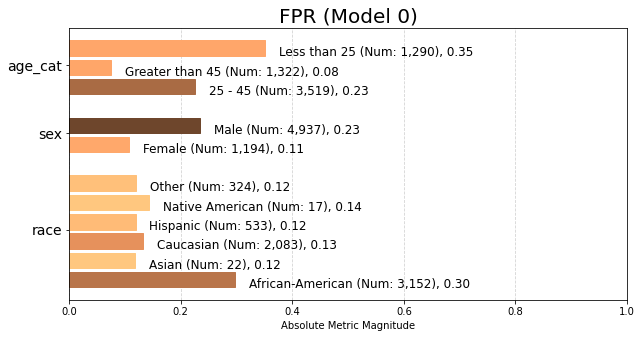

In [216]:
aq_plot = Plot()
fpr = aq_plot.plot_group_metric(group_table=grp_table,
                               group_metric="fpr")

In [220]:
aq_bias = Bias()
bias_dpg_pay_attention = aq_bias.get_disparity_min_metric(grp_table, 
                                           original_df=df_compas_train_val_result)

get_disparity_min_metric()


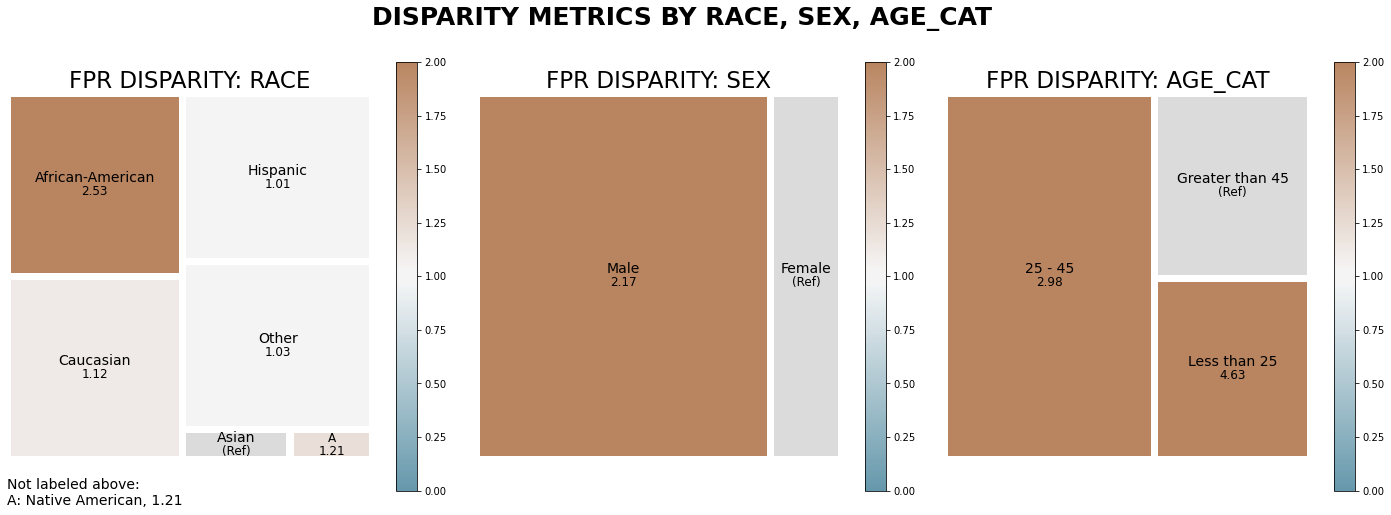

In [221]:
fpr_disp_plot_pay_attention = aq_plot.plot_disparity_all(bias_dpg_pay_attention,
                                           attributes=["race", "sex", "age_cat"],
                                           metrics=['fpr_disparity'])

In [229]:
aq_bias = Bias()
bias_dpg = aq_bias.get_disparity_predefined_groups(grp_table, 
                                        original_df=df_compas_train_val_result,
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


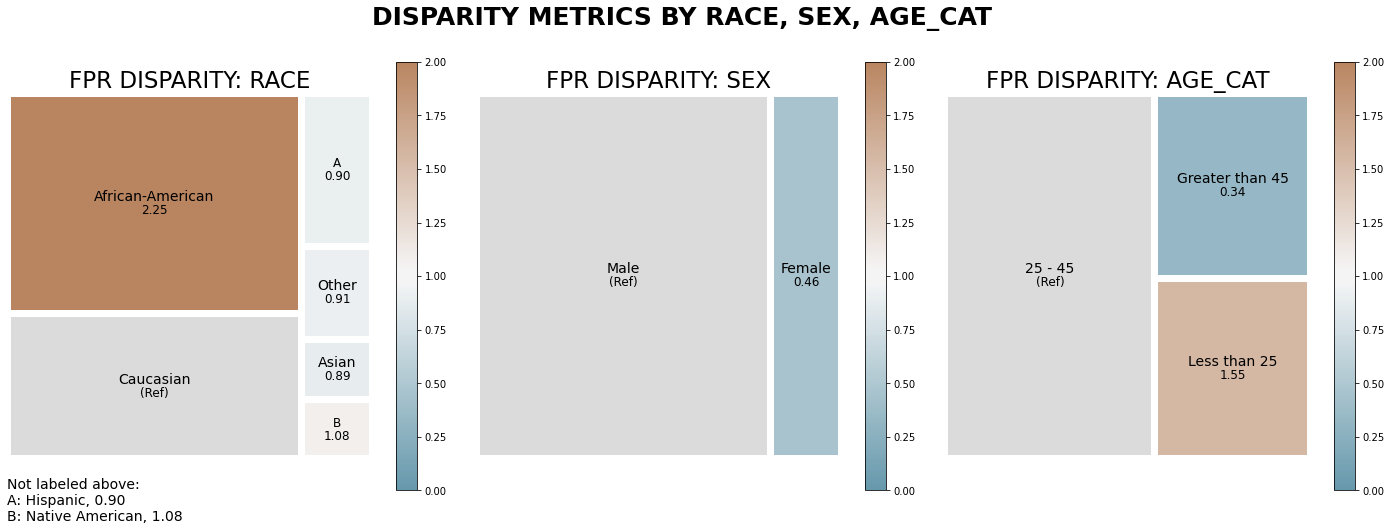

In [230]:
fpr_disp_plot = aq_plot.plot_disparity_all(bias_dpg,
                                           attributes=["race", "sex", "age_cat"],
                                           metrics=['fpr_disparity'])

In [231]:
aq_fairness = Fairness()

In [232]:
fairness_table = aq_fairness.get_group_value_fairness(bias_dpg, tau=0.8)
fairness_table

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,2392,race,African-American,0.732962,0.702211,0.285242,0.279098,0.297789,0.267038,0.714758,0.720902,1641,1511,0.686037,0.520622,458,431,1080,1183,1614,1538,3152,6131,0.512056,3.107955,2.053893,1.054394,0.882418,0.966341,2.252143,0.477062,1.664899,0.809208,1.014096,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False
1,0,binary 0/1,2392,race,Asian,0.600000,0.882353,0.117647,0.400000,0.117647,0.400000,0.882353,0.600000,5,17,0.002090,0.227273,2,2,15,3,5,17,22,6131,0.227273,0.009470,0.896608,0.877562,1.264671,0.398565,0.889750,0.714597,1.362881,1.016799,1.251878,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False
2,0,binary 0/1,2392,race,Caucasian,0.440244,0.867775,0.295177,0.316288,0.132225,0.559756,0.704823,0.683712,528,1555,0.220736,0.253481,167,459,1096,361,820,1263,2083,6131,0.393663,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,0,binary 0/1,2392,race,Hispanic,0.446701,0.880952,0.269136,0.312500,0.119048,0.553299,0.730864,0.687500,128,405,0.053512,0.240150,40,109,296,88,197,336,533,6131,0.369606,0.242424,0.947410,1.005540,0.988024,0.911778,0.900342,0.988465,1.014666,1.015185,1.036947,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
4,0,binary 0/1,2392,race,Native American,0.800000,0.857143,0.250000,0.111111,0.142857,0.200000,0.750000,0.888889,9,8,0.003763,0.529412,1,2,6,8,10,7,17,6131,0.588235,0.017045,2.088570,1.300092,0.351297,0.846950,1.080411,0.357298,1.817175,0.987748,1.064097,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,True,True,False,False,True,True,False,False,False,False,False,False
5,0,binary 0/1,2392,race,Other,0.478632,0.879227,0.251029,0.308642,0.120773,0.521368,0.748971,0.691358,81,243,0.033863,0.250000,25,61,182,56,117,207,324,6131,0.361111,0.153409,0.986269,1.011183,0.975826,0.850435,0.913391,0.931419,1.087198,1.013197,1.062637,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
6,0,binary 0/1,2392,sex,Female,0.451765,0.892068,0.253536,0.301818,0.107932,0.548235,0.746464,0.698182,275,919,0.114967,0.230318,83,233,686,192,425,769,1194,6131,0.355946,0.129901,0.537119,0.980790,1.047458,0.860376,0.459863,1.542448,0.700880,1.165653,1.058334,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False
7,0,binary 0/1,2392,sex,Male,0.644568,0.765294,0.294681,0.288144,0.234706,0.355432,0.705319,0.711856,2117,2820,0.885033,0.428803,610,831,1989,1507,2338,2599,4937,6131,0.473567,1.000000,1.000000,

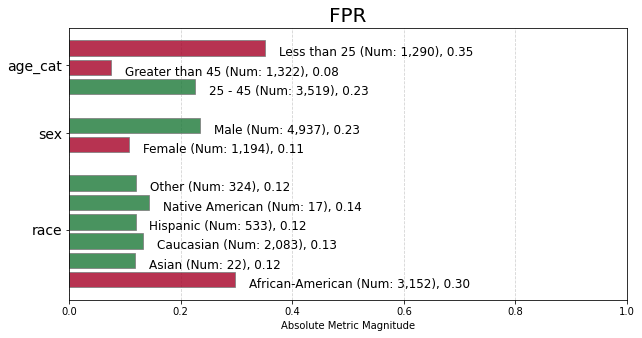

In [233]:
fpr_fairness_plot = aq_plot.plot_fairness_group(fairness_table,
                                                group_metric="fpr",
                                                title="FPR")

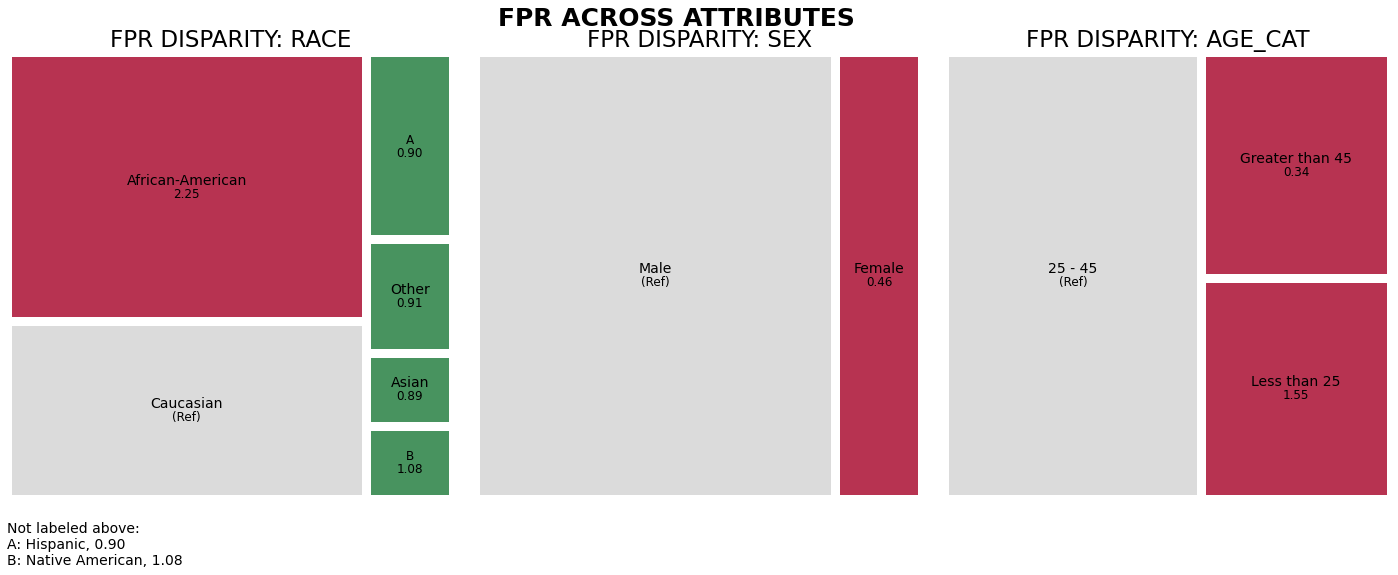

In [234]:
fpr_fnr_fairness_disparity_plot = aq_plot.plot_fairness_disparity_all(fairness_table,
                                                                    metrics=["fpr"])

In [235]:
import aequitas.plot as ap 

In [240]:
ap.disparity(bias_dpg, ["fpr"], "race", fairness_threshold = 1.3)

alt.LayerChart(...)